# Reference
[uproot documentation](https://uproot.readthedocs.io/en/latest/)

In [1]:
def make_sequential(obj):
    seq_events = np.zeros_like(obj.event)
    seq_events[0] = obj.event[0]
    seq_event = 0
    seq_files = np.zeros_like(obj.event)
    seq_files[0] = obj.event[0]
    seq_file = 0
    for i in range(1, len(obj.event)):
        if obj.event[i] != obj.event[i - 1]:
            seq_event += 1
        if obj.event[i] < obj.event[i - 1]:
            seq_file += 1
        seq_events[i] = seq_event
        seq_files[i] = seq_file
    obj.event = seq_events
    obj.file = seq_files

In [2]:
import uproot, numpy as np


# def make_semilog_binning(low, high):
#     space = []
#     for i in range(int(np.floor(np.log10(low))), int(np.ceil(np.log10(high)))):
#         this_space = np.linspace(10**i, 10**(i + 1), 10)
#         space.append(this_space[1:] if space else this_space)
#     space = np.concatenate(space)
#     print(space)
#     return space

def make_semilog_binning(low, high):
    space = np.linspace(0,120,41)
    print(space)
    return space

class MCValidation:
    def __init__(self, filename, treename):
        file = uproot.open(filename)
        tree = file[treename]
        
        self.event = tree['event'].array(library="np") #linear list of events
        self.orig_event = tree["event"].array(library="np") #actual event number
        self.file = np.zeros_like(self.event)
        self.mc_id = tree["mcId"].array(library="np") #number of mc particles in event
        self.mc_pdg = tree["mcPDG"].array(library="np") #pdg code of particles in each event
        self.mc_tier = tree["mcTier"].array(library="np") #Which tier each event is folded back to
        self.mc_nhits = tree["mcNHits"].array(library="np") #number of mc particles hits in event
        self.mc_momentum = tree["mcMomentum"].array(library="np") #momentum of mc particles in event
        is_nu_int = tree["isNuInteration"].array(library="np") #not functioning
        is_cr_int = tree["isCosmicRay"].array(library="np") #not functioning
        is_tb_int = tree["isTestBeam"].array(library="np") #not functioning
        self.environment = np.full(is_nu_int.shape, "??") #not functioning
        self.environment[np.where(is_nu_int)] = "nu" #not functioning
        self.environment[np.where(is_cr_int)] = "tb" #not functioning
        self.environment[np.where(is_tb_int)] = "cr" #not functioning
        self.is_leading_lepton = tree["isLeadingLepton"].array(library="np")
        self.is_michel = tree["isMichel"].array(library="np")
        self.n_matches = tree["nMatches"].array(library="np")
        self.reco_id_list = tree["recoIdVector"].array(library="np")
        self.reco_nhits_list = tree["nRecoHitsVector"].array(library="np")
        self.shared_nhits_list = tree["nSharedHitsVector"].array(library="np")
        self.purity_adc_list = tree["purityAdcVector"].array(library="np")
        self.purity_list = tree["purityVector"].array(library="np")
        self.purity_list_u = tree["purityVectorU"].array(library="np")
        self.purity_list_v = tree["purityVectorV"].array(library="np")
        self.purity_list_w = tree["purityVectorW"].array(library="np")
        self.purity_adc_list_u = tree["purityAdcVectorU"].array(library="np")
        self.purity_adc_list_v = tree["purityAdcVectorV"].array(library="np")
        self.purity_adc_list_w = tree["purityAdcVectorW"].array(library="np")
        self.completeness_list = tree["completenessVector"].array(library="np")
        self.completeness_adc_list = tree["completenessAdcVector"].array(library="np")
        self.completeness_list_u = tree["completenessVectorU"].array(library="np")
        self.completeness_list_v = tree["completenessVectorV"].array(library="np")
        self.completeness_list_w = tree["completenessVectorW"].array(library="np")
        self.completeness_adc_list_u = tree["completenessAdcVectorU"].array(library="np")
        self.completeness_adc_list_v = tree["completenessAdcVectorV"].array(library="np")
        self.completeness_adc_list_w = tree["completenessAdcVectorW"].array(library="np")
        self.is_cc = tree["isCC"].array(library="np")
        self.is_qe = tree["isQE"].array(library="np")
        self.is_res = tree["isResonant"].array(library="np")
        self.is_dis = tree["isDIS"].array(library="np")
        self.is_coh = tree["isCoherent"].array(library="np")
        self.is_numu = tree["isNuMu"].array(library="np")
        self.is_nue = tree["isNuE"].array(library="np")
        self.n_pizero = tree["nPiZero"].array(library="np")
        self.n_pic = tree["nPiMinus"].array(library="np") + tree["nPiPlus"].array(library="np")
        self.n_photons = tree["nPhotons"].array(library="np")
        self.n_protons = tree["nProtons"].array(library="np")
        self.pc_metric = self.purity_adc_list * self.completeness_adc_list
        file.close()
        make_sequential(self)

import matplotlib.pyplot as plt

class PlotFormat:
    def __init__(self, title="", xlabel="x", ylabel="y", xlim=None, ylim=None, titlesize=24, labelsize=18, is_logx=False,
                is_semilogx=False, is_logy=False, is_semilogy=False, filename="placeholder"):
        self.title = title
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.xlim = xlim
        self.ylim = ylim
        self.titlesize = titlesize
        self.labelsize = labelsize
        self.is_logx = is_logx
        self.is_logy = is_logy
        self.is_semilogx = is_semilogx
        self.is_semilogy = is_semilogy
        self.filename = filename

class Metric:
    def __init__(self, bin_var, bins):
        self.low = bins[0]
        self.high = bins[-1]
        self.bins = bins
        self.n_bins = len(bins) - 1
        self.x = bins
        self.y = np.zeros_like(self.x)
        self.y_err_low = np.zeros_like(self.y)
        self.y_err_high = np.zeros_like(self.y)
        self.y_errs = np.array(list(zip(self.y_err_low, self.y_err_high))).T
    
    def suppress_empty(self, empty_val=-1):
        selection_idx = np.where(self.y != empty_val)
        self.y = self.y[selection_idx]
        self.x = self.x[selection_idx]
        self.y_err_low = self.y_err_low[selection_idx]
        self.y_err_high = self.y_err_high[selection_idx]
        self.y_errs = np.array(list(zip(self.y_err_high, self.y_err_low))).T

In [3]:
def get_efficiency(efficiency, bin_var, bins):
    metrics = dict()
    for key, value in efficiency.items():
        metrics[key] = Metric(bin_var[key], bins)
        metric = metrics[key]
    
        for i in range(metric.n_bins):
            if i > (metric.n_bins - 1):
                idx = np.where((bin_var[key] >= metric.bins[i]) & (bin_var[key] < (metric.bins[i + 1])))
            else:
                idx = np.where((bin_var[key] >= metric.bins[i]) & (bin_var[key] <= (metric.bins[i + 1])))
            if len(idx[0]) > 0:
                selection = efficiency[key][idx]
                metric.y[i] = np.mean(selection)
                metric.y_err_low[i] = metric.y_err_high[i] = np.sqrt(metric.y[i] * (1 - metric.y[i]) / len(selection))
            else:
                metric.y[i] = -1

        metric.suppress_empty()
    
    return metrics

def get_purity_or_completeness(p_or_c, bin_var, bins):
    metrics = dict()
    for key, value in p_or_c.items():
        metrics[key] = Metric(bin_var[key], bins)
        metric = metrics[key]
    
        for i in range(metric.n_bins):
            if i > (metric.n_bins - 1):
                idx = np.where((bin_var[key] >= metric.bins[i]) & (bin_var[key] < (metric.bins[i + 1])))
            else:
                idx = np.where((bin_var[key] >= metric.bins[i]) & (bin_var[key] <= (metric.bins[i + 1])))
            if len(idx[0]) > 0:
                selection = p_or_c[key][idx]
                metric.y[i] = np.median(selection)
                metric.y_err_low[i], metric.y_err_high[i] = np.quantile(selection, [0.5 - 0.34135, 0.5 + 0.34135])
            else:
                metric.y[i] = -1

        metric.suppress_empty()
    
    return metrics

def get_purity(p, bin_var, bins):
    return get_purity_or_completeness(p, bin_var, bins)

def get_completeness(c, bin_var, bins):
    return get_purity_or_completeness(c, bin_var, bins)

def get_purity_or_completeness_fraction(p_or_c, metric, plot_format):
    plt.rcParams["figure.figsize"] = (15, 10)
    fig, ax = plt.subplots()
    
    ax.set_title(plot_format.title, fontsize=plot_format.titlesize)
    ax.tick_params(axis='x', labelsize=plot_format.labelsize)
    ax.tick_params(axis='y', labelsize=plot_format.labelsize)
    ax.set_xlabel(plot_format.xlabel, fontsize=plot_format.titlesize)
    ax.set_ylabel(plot_format.ylabel, fontsize=plot_format.titlesize)
    if not plot_format.xlim is None:
        plt.xlim(plot_format.xlim[0], plot_format.xlim[1])
    if not plot_format.ylim is None:
        plt.ylim(plot_format.ylim[0], plot_format.ylim[1])

    for key, value in p_or_c.items():
        bins = np.linspace(0, 1, 21)
        weights = np.ones_like(p_or_c[key]) / len(p_or_c[key])
        h, _ = np.histogram(p_or_c[key], bins=bins)
        idx = np.where(h > 0)
        e = np.array([ np.sqrt(val) / val if val > 0 else 0 for val in h ])
        y, _ = np.histogram(p_or_c[key], bins=bins, weights=weights)
        x = (bins[1:] + bins[:-1]) / 2

        y = y[idx]
        x = x[idx]
        e = e[idx] * y
    
        plt.errorbar(x, y, xerr=0.05 / 2, yerr = e, fmt='o', lw=2, markersize = '4', elinewidth=2, label=f"{key}")
    plt.legend(fontsize=plot_format.titlesize)
    
    plt.tight_layout()
    save_plot(fig, plot_format.filename)
    
    plt.show()

def get_purity_fraction(purity, plot_format):
    get_purity_or_completeness_fraction(purity, "purity", plot_format)
    
def get_completeness_fraction(completeness, plot_format):
    get_purity_or_completeness_fraction(completeness, "completeness", plot_format)
    
def plot_metric(metrics, plot_format, metric="completeness"):
    plt.rcParams["figure.figsize"] = (15, 10)
    fig, ax = plt.subplots()
    
    ax.set_title(plot_format.title, fontsize=plot_format.titlesize)
    ax.tick_params(axis='x', labelsize=plot_format.labelsize)
    ax.tick_params(axis='y', labelsize=plot_format.labelsize)
    ax.set_xlabel(plot_format.xlabel, fontsize=plot_format.titlesize)
    ax.set_ylabel(plot_format.ylabel, fontsize=plot_format.titlesize)
    if plot_format.is_logx:
        plt.logx()
    elif plot_format.is_semilogx:
        plt.semilogx()
    if plot_format.is_logy:
        plt.logy()
    elif plot_format.is_semilogy:
        plt.semilogy()
    if not plot_format.xlim is None:
        plt.xlim(plot_format.xlim[0], plot_format.xlim[1])
    if not plot_format.ylim is None:
        plt.ylim(plot_format.ylim[0], plot_format.ylim[1])
    
    if metric.lower() in ['purity', 'completeness']:
        for key, value in metrics.items():
            x, y, err = value.x, value.y, value.y_errs
            plt.plot(x, y, lw=2, label = f"{key}")
            color = plt.gca().lines[-1].get_color()
            plt.plot(x, err[0], color=color, lw=2, linestyle='dashed')
            plt.plot(x, err[1], color=color, lw=2, linestyle='dashed')
        plt.legend(fontsize=plot_format.titlesize)
    elif metric.lower() == 'efficiency':
        for key, value in metrics.items():
            x, y, err = value.x, value.y, value.y_errs
            bin_width = (x[1] - x[0])
            plt.errorbar(x, y, xerr=bin_width / 2, yerr = err, fmt='o', markersize = '4', lw=2, elinewidth=2,
                         label = f"{key}")
        plt.legend(fontsize=plot_format.titlesize)
    
    plt.tight_layout()
    save_plot(fig, plot_format.filename)
    
    plt.show()

In [4]:
import os

def save_plot(fig, filename, subdir=None):
    if subdir is None:
        subdir = ""
    elif subdir.startswith("/"):
        subdir = subdir[1:]
        
    if not os.path.exists('images'):
        os.mkdir('images')
    for img_type in [ "png", "svg", "eps" ]:
        if not os.path.exists(f'images/{img_type}'):
            os.mkdir(f'images/{img_type}')
        if not os.path.exists(f'images/{img_type}/{subdir}'):
            os.mkdir(f'images/{img_type}/{subdir}')
        fig.savefig(f'images/{img_type}/{subdir}/{filename}.{img_type}', dpi=200, facecolor='w')

In [64]:
def get_metric_arrays(validation, idx):
    completeness = validation.completeness_list[idx]
    purity = validation.purity_list[idx]

    index_array = [ np.argmax(val) if len(val) > 0 else -1 for val in completeness ] 
    completeness_array = np.array([ np.max(val) if len(val) > 0 else 0 for val in completeness ])
    purity_array = np.array([ purity[i][index_array[i]] if index_array[i] != -1 else 0 for i in range(len(purity)) ])
    
    efficiency_array = np.array((completeness_array >= 0.5) & (purity_array >= 0.5))

    return purity_array, completeness_array, efficiency_array

def make_completeness_plots(pdg, completeness_array, mc_nhits, mc_mom, filename):
    if filename.lower().startswith("inc"):
        title = str(pdg_to_id[pdg])
    else:
        title = str(pdg_to_id[pdg]) + " - " + filename[:filename.find("_")].upper()

    combined = np.concatenate(list(mc_nhits.values()))
    bins = make_semilog_binning(np.min(combined), np.max(combined))
    plot_format = PlotFormat(title=title, xlabel="num true hits", ylabel="completeness",
                             xlim=(1, np.max(combined)), ylim=(0, 1.01), is_semilogx=True, filename=f"{filename}_nhits")
    metrics = get_completeness(completeness_array, mc_nhits, bins)
    plot_metric(metrics, plot_format, "completeness")

    combined = np.concatenate(list(mc_mom.values()))
    bins = np.linspace(0, 30, 61)
    plot_format = PlotFormat(title=title, xlabel="true momentum (GeV)", ylabel="completeness",
                             xlim=(0, min(30, np.max(combined))), ylim=(0, 1.01), filename=f"{filename}_mom")
    metrics = get_completeness(completeness_array, mc_mom, bins)
    plot_metric(metrics, plot_format, "completeness")

    plot_format = PlotFormat(title=title, xlabel="completeness", ylabel="fraction",
                             xlim=(0, 1), ylim=(0, 1.01), filename=f"{filename}_frac")
    get_completeness_fraction(completeness_array, plot_format)

def make_purity_plots(pdg, purity_array, mc_nhits, mc_mom, filename):
    if filename.lower().startswith("inc"):
        title = str(pdg_to_id[pdg])
    else:
        title = str(pdg_to_id[pdg]) + " - " + filename[:filename.find("_")].upper()
    
    combined = np.concatenate(list(mc_nhits.values()))
    bins = make_semilog_binning(np.min(combined), np.max(combined))
    plot_format = PlotFormat(title=title, xlabel="num true hits", ylabel="purity",
                             xlim=(1, np.max(combined)), ylim=(0, 1.01), is_semilogx=True, filename=f"{filename}_nhits")
    metrics = get_purity(purity_array, mc_nhits, bins)
    plot_metric(metrics, plot_format, "purity")

    combined = np.concatenate(list(mc_mom.values()))
    bins = np.linspace(0, 30, 61)
    plot_format = PlotFormat(title=title, xlabel="true momentum (GeV)", ylabel="purity",
                             xlim=(0, min(30, np.max(combined))), ylim=(0, 1.01), filename=f"{filename}_mom")
    metrics = get_purity(purity_array, mc_mom, bins)
    plot_metric(metrics, plot_format, "purity")

    plot_format = PlotFormat(title=title, xlabel="purity", ylabel="fraction", xlim=(0, 1), ylim=(0, 1.01),
                             filename=f"{filename}_frac")
    get_purity_fraction(purity_array, plot_format)

def make_efficiency_plots(pdg, efficiency_array, mc_nhits, mc_mom, filename):
    if filename.lower().startswith("inc"):
        title = str(pdg_to_id[pdg])
    else:
        title = str(pdg_to_id[pdg]) + " - " + filename[:filename.find("_")].upper()

    combined = np.concatenate(list(mc_nhits.values()))
    bins = make_semilog_binning(np.min(combined), np.max(combined))
    plot_format = PlotFormat(title=title, xlabel="num true hits", ylabel="efficiency",
                             xlim=(1, np.max(combined)), ylim=(0, 1.01), is_semilogx=False, filename=f"{filename}_nhits")
    metrics = get_efficiency(efficiency_array, mc_nhits, bins)
    plot_metric(metrics, plot_format, "efficiency")

    combined = np.concatenate(list(mc_mom.values()))
    bins = np.linspace(0, 30, 61)
    plot_format = PlotFormat(title=title, xlabel="true momentum (GeV)", ylabel="efficiency",
                             xlim=(0, min(30, np.max(combined))), ylim=(0, 1.01), filename=f"{filename}_mom")
    metrics = get_efficiency(efficiency_array, mc_mom, bins)
    plot_metric(metrics, plot_format, "efficiency")

In [6]:
pdg_to_id = {11: r"$e$", 13: r"$\mu$", 22: r"$\gamma$", 211: r"$\pi$", 2212: r"$p$"}

In [65]:
pdg_to_id = {11: r"$e$", 22: r"$\gamma$"}

# MC validation

In [107]:
validation1 = MCValidation("../../run/hierarchy_validation_LowE_DL_cheatmerge_all_energies.root", "mc")
validation2 = MCValidation("../../run/hierarchy_validation_LowE_DL_cheatmerge_config5_all_energies.root", "mc")

## Inclusive particle metrics

[  0.   3.   6.   9.  12.  15.  18.  21.  24.  27.  30.  33.  36.  39.
  42.  45.  48.  51.  54.  57.  60.  63.  66.  69.  72.  75.  78.  81.
  84.  87.  90.  93.  96.  99. 102. 105. 108. 111. 114. 117. 120.]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


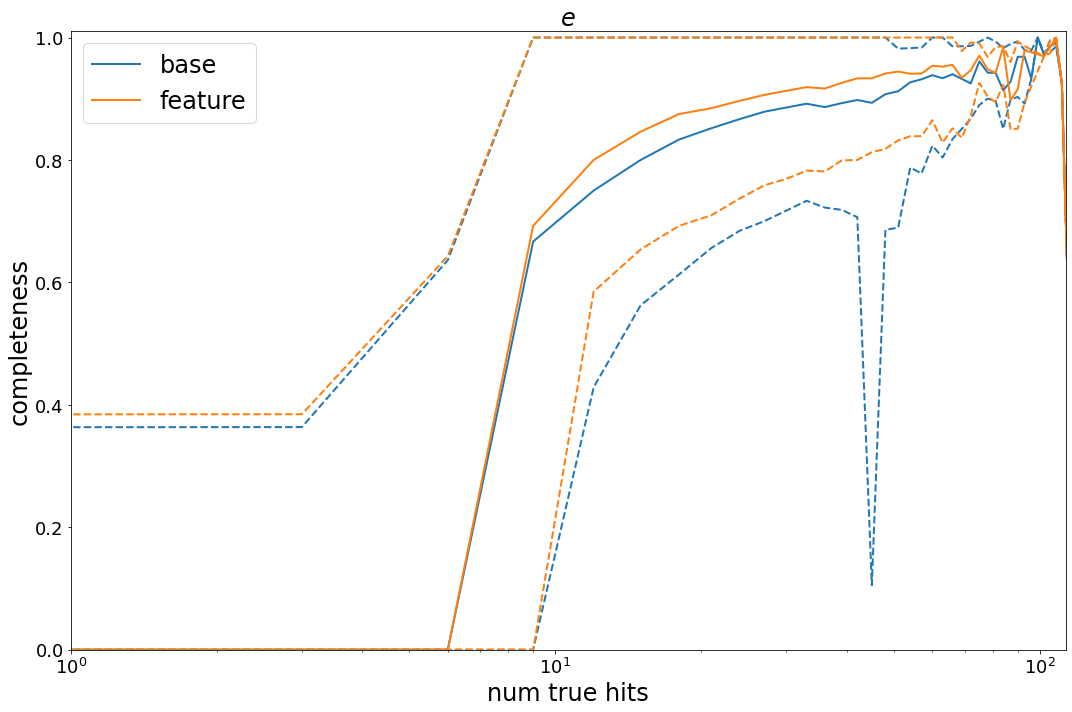

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


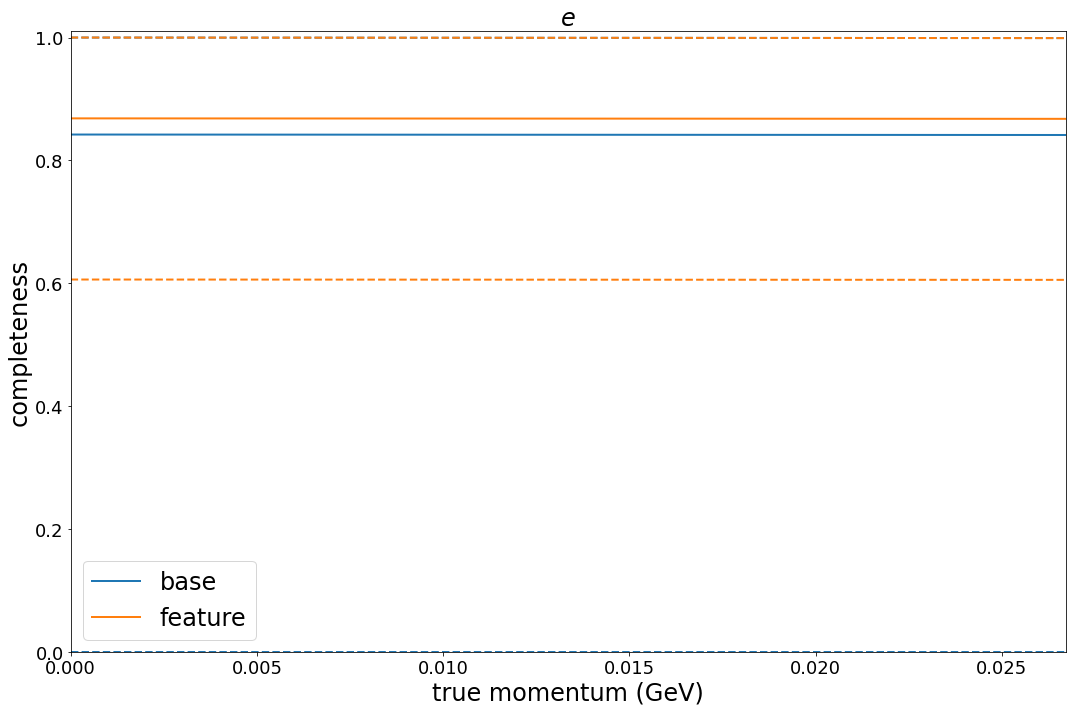

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


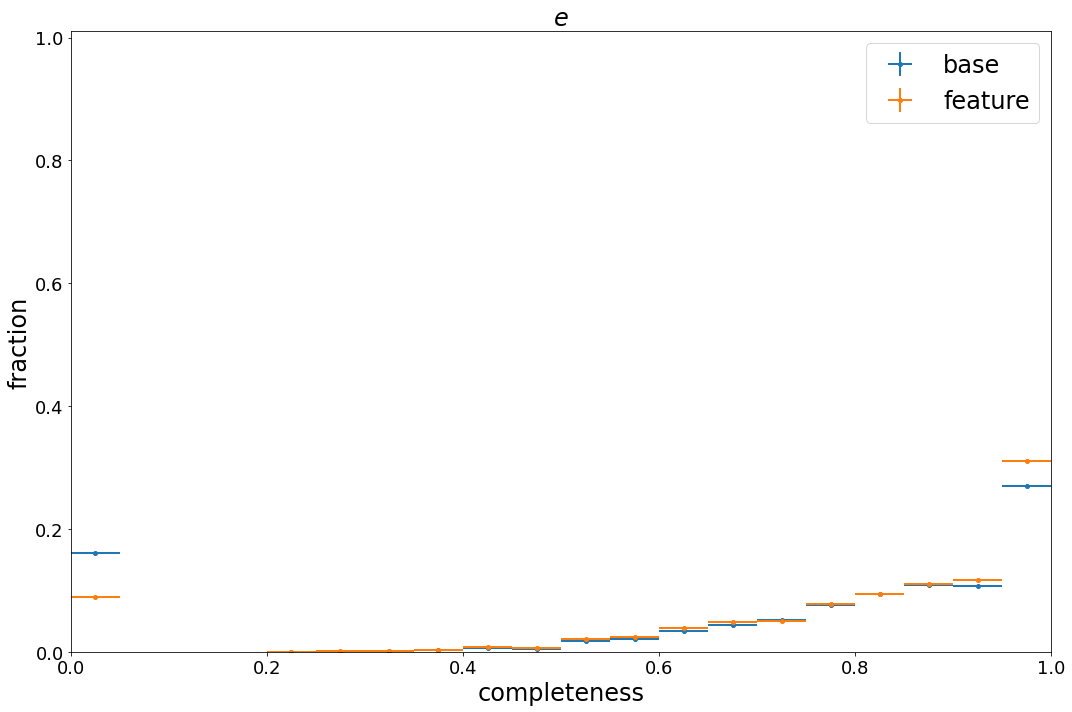

[  0.   3.   6.   9.  12.  15.  18.  21.  24.  27.  30.  33.  36.  39.
  42.  45.  48.  51.  54.  57.  60.  63.  66.  69.  72.  75.  78.  81.
  84.  87.  90.  93.  96.  99. 102. 105. 108. 111. 114. 117. 120.]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


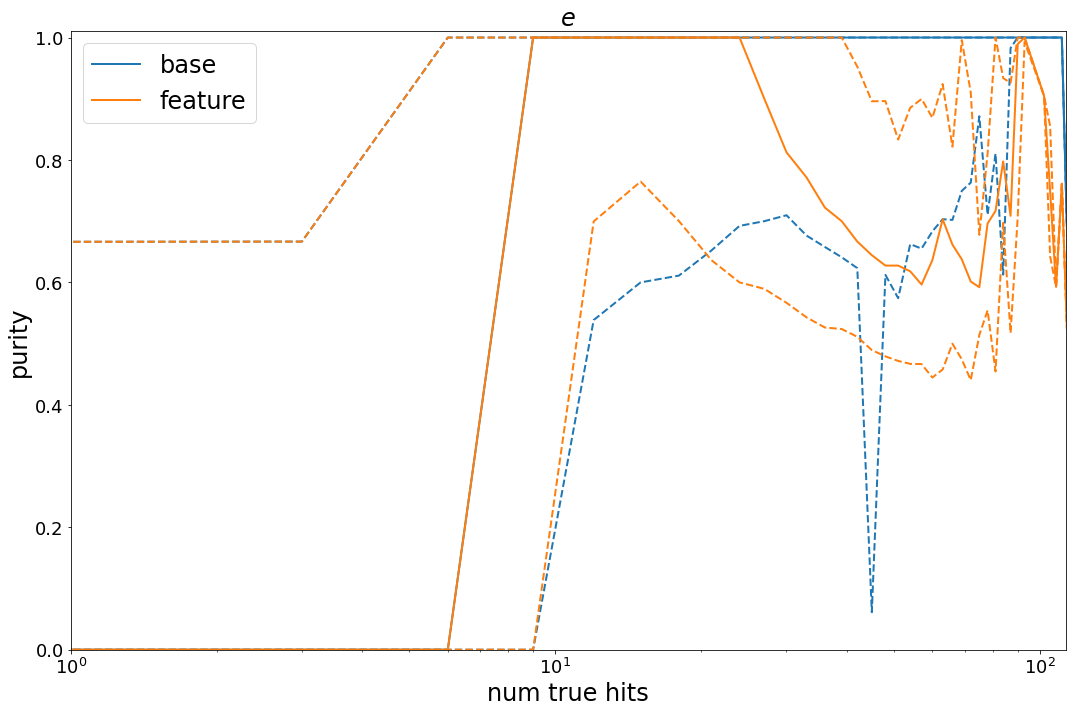

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


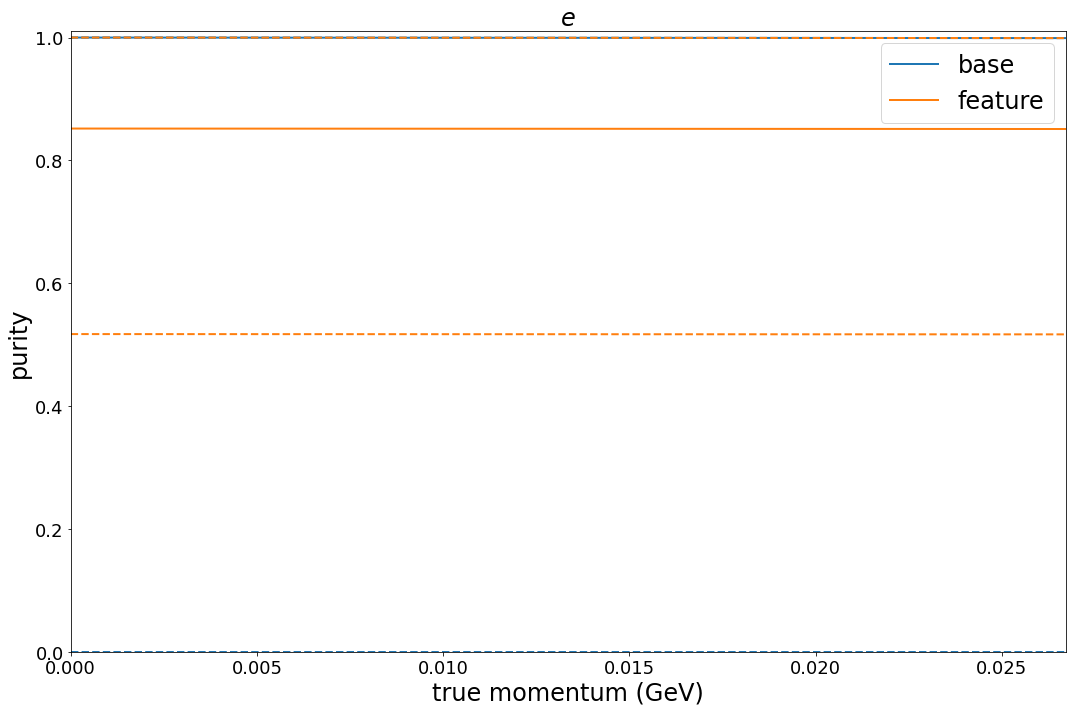

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


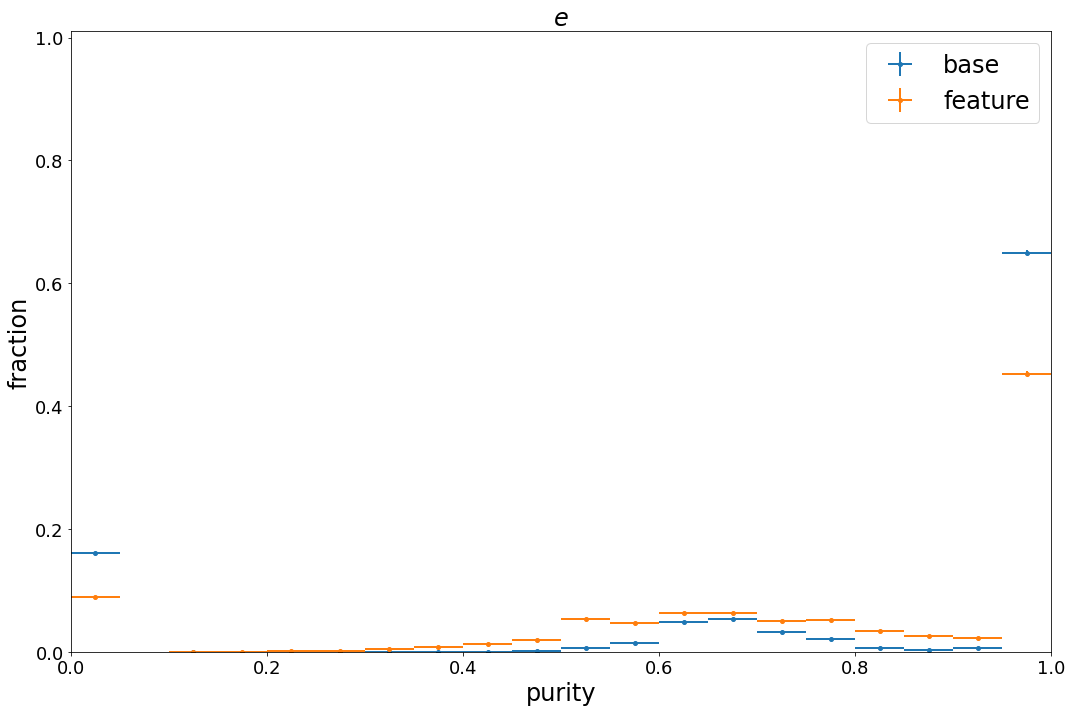

[  0.   3.   6.   9.  12.  15.  18.  21.  24.  27.  30.  33.  36.  39.
  42.  45.  48.  51.  54.  57.  60.  63.  66.  69.  72.  75.  78.  81.
  84.  87.  90.  93.  96.  99. 102. 105. 108. 111. 114. 117. 120.]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


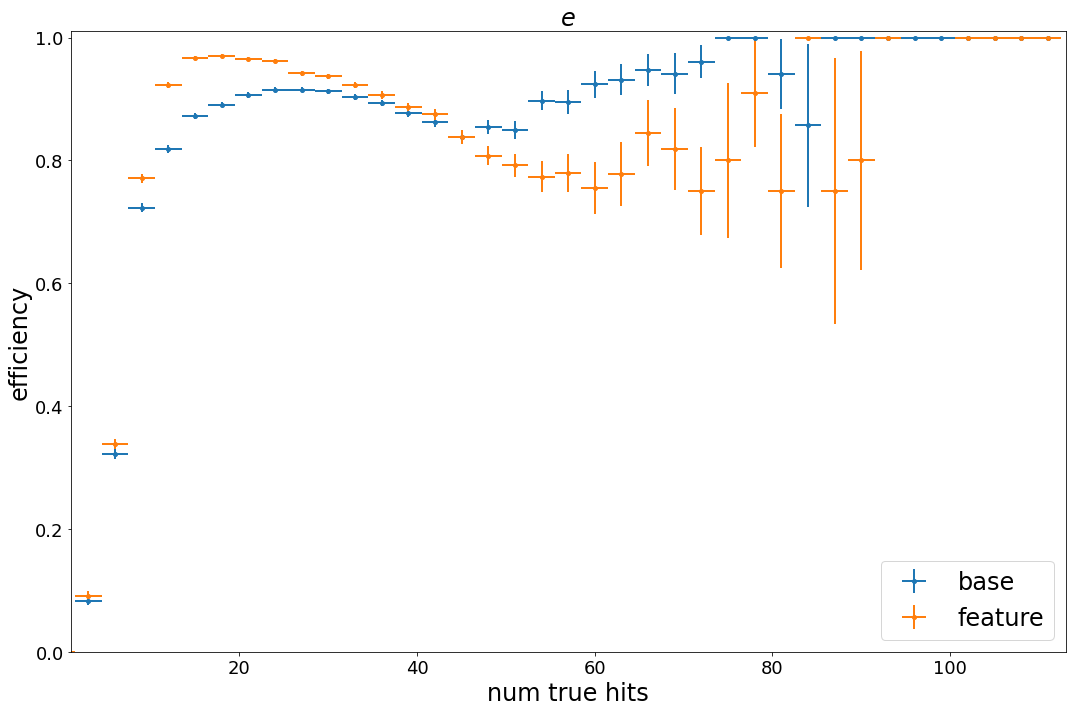

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


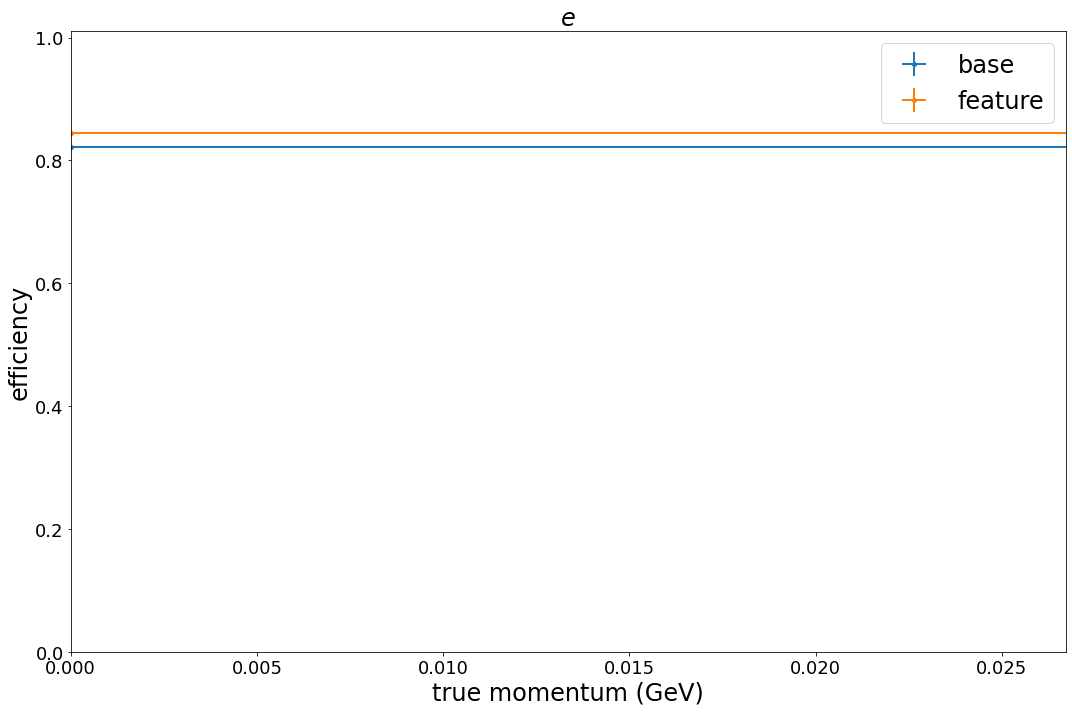

[  0.   3.   6.   9.  12.  15.  18.  21.  24.  27.  30.  33.  36.  39.
  42.  45.  48.  51.  54.  57.  60.  63.  66.  69.  72.  75.  78.  81.
  84.  87.  90.  93.  96.  99. 102. 105. 108. 111. 114. 117. 120.]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


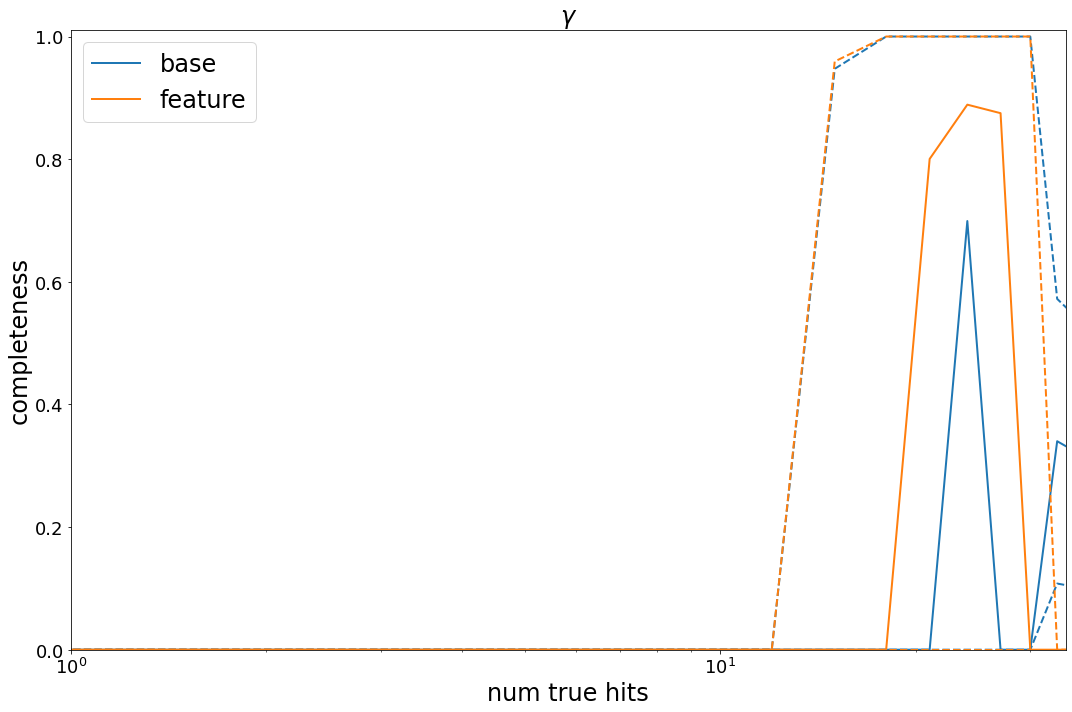

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


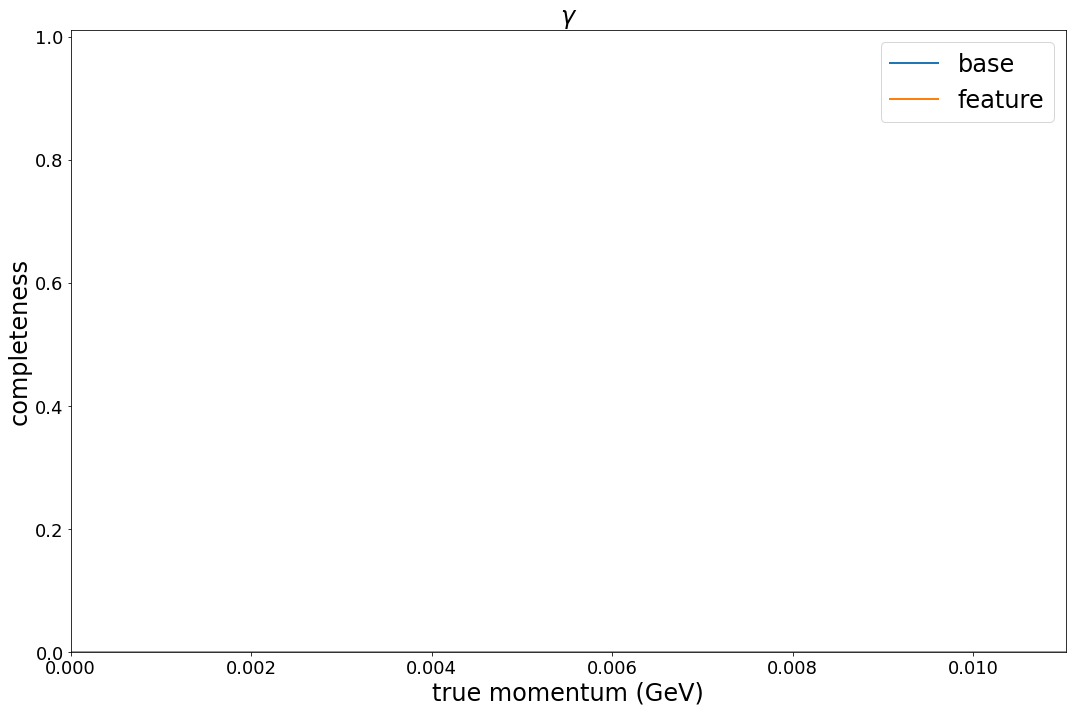

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


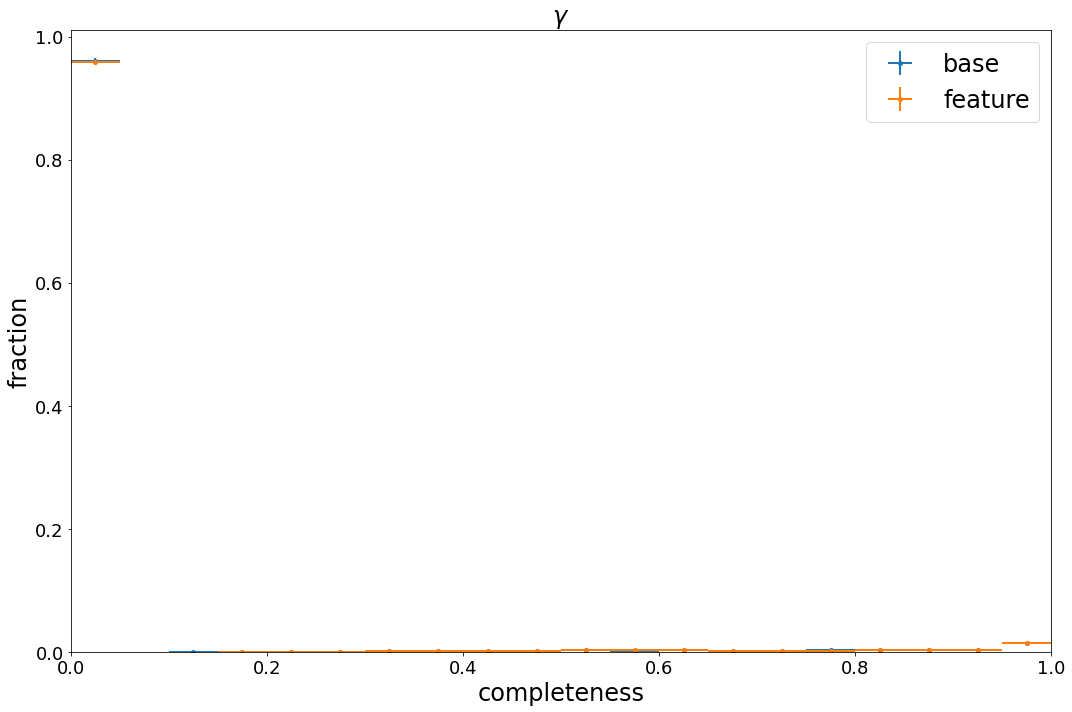

[  0.   3.   6.   9.  12.  15.  18.  21.  24.  27.  30.  33.  36.  39.
  42.  45.  48.  51.  54.  57.  60.  63.  66.  69.  72.  75.  78.  81.
  84.  87.  90.  93.  96.  99. 102. 105. 108. 111. 114. 117. 120.]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


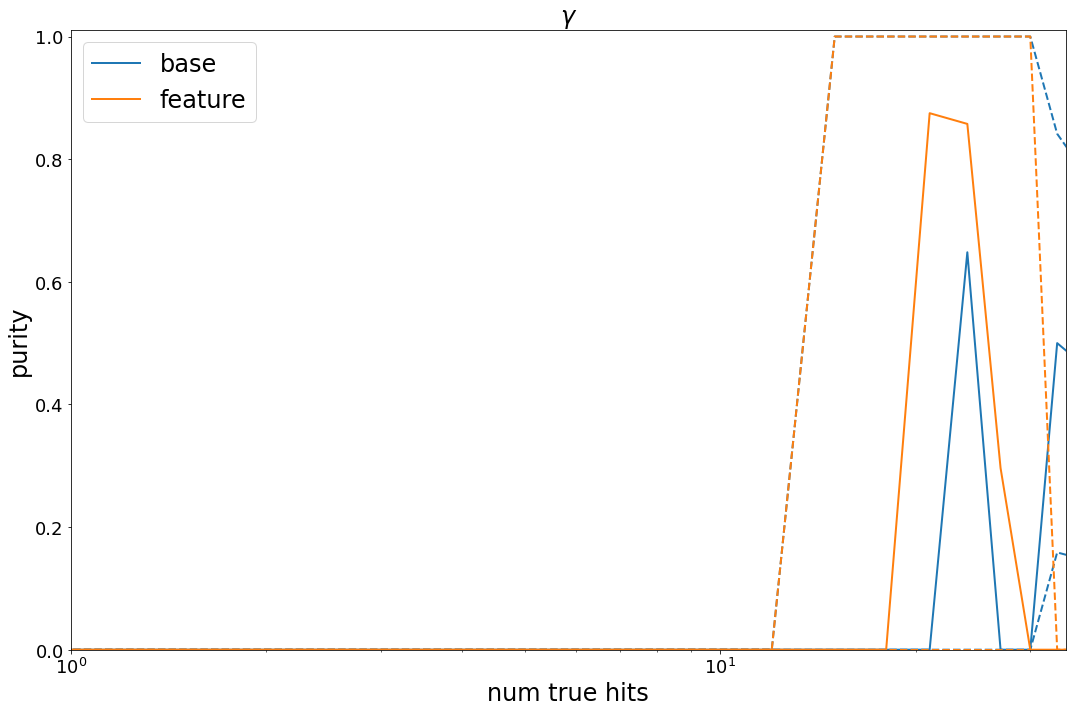

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


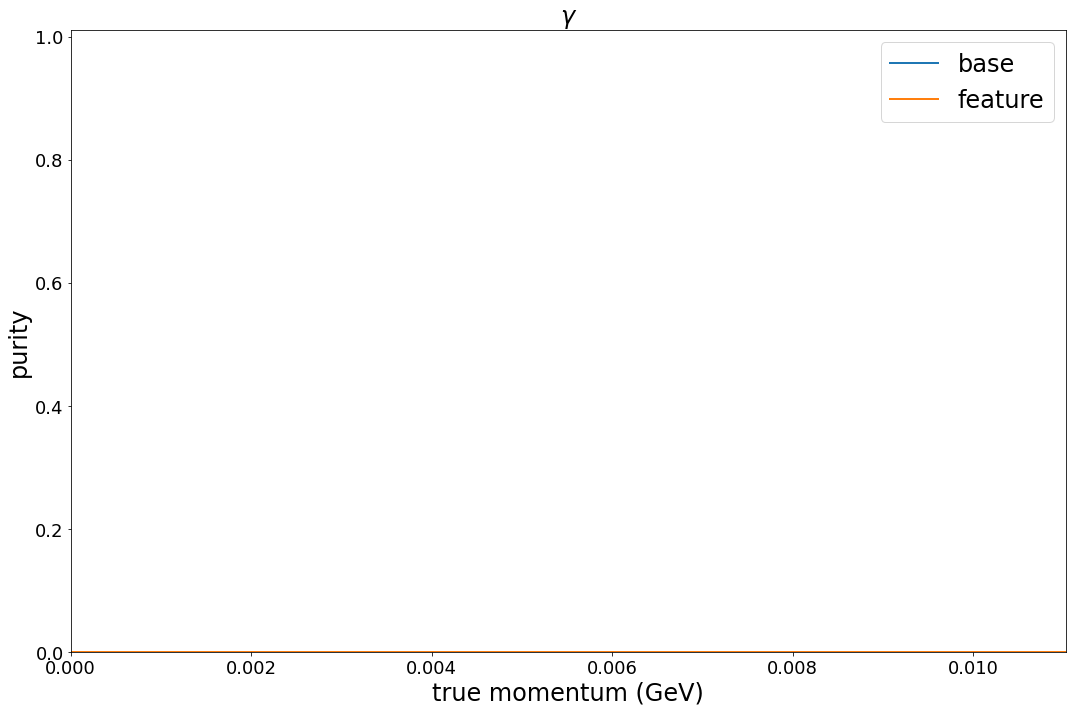

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


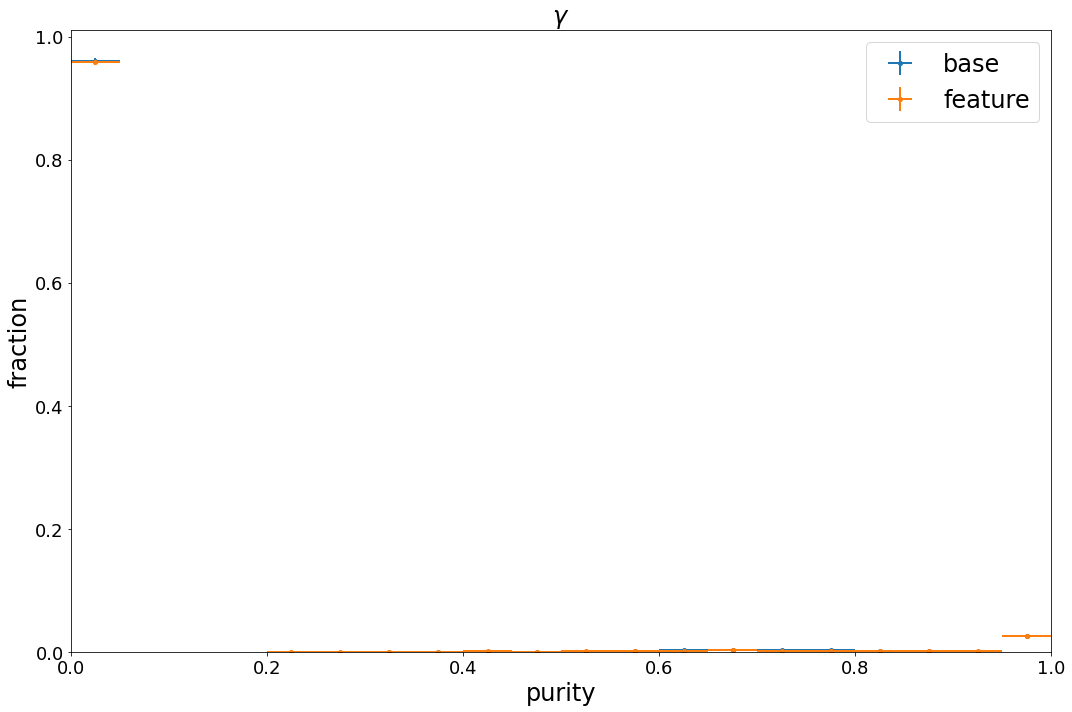

[  0.   3.   6.   9.  12.  15.  18.  21.  24.  27.  30.  33.  36.  39.
  42.  45.  48.  51.  54.  57.  60.  63.  66.  69.  72.  75.  78.  81.
  84.  87.  90.  93.  96.  99. 102. 105. 108. 111. 114. 117. 120.]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


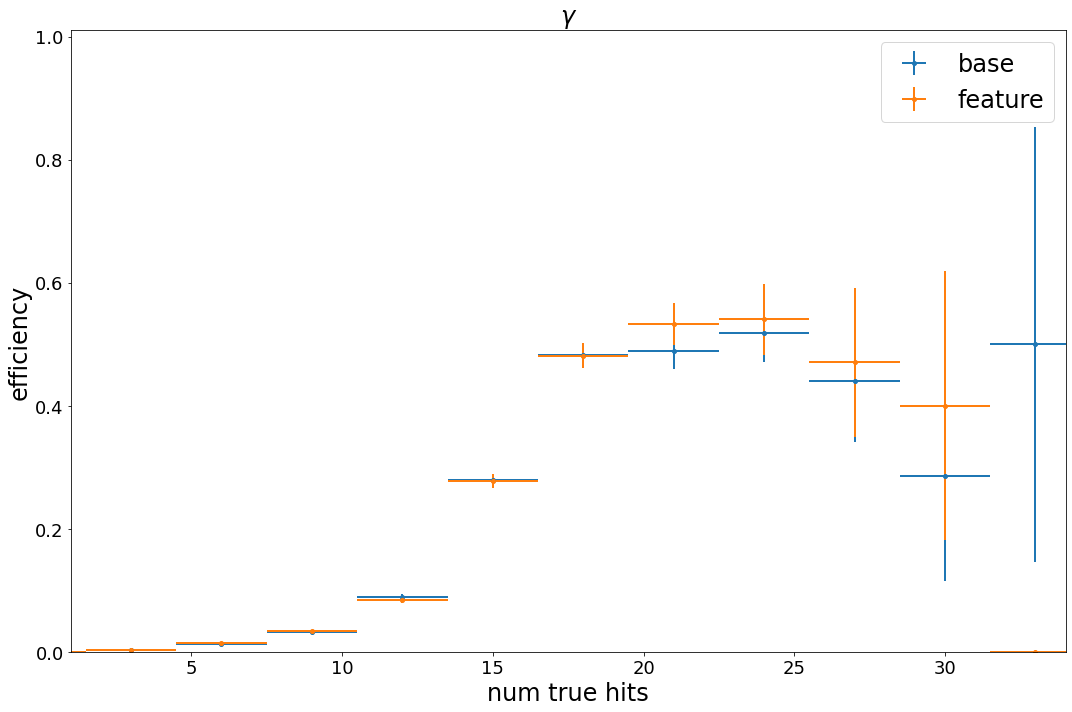

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


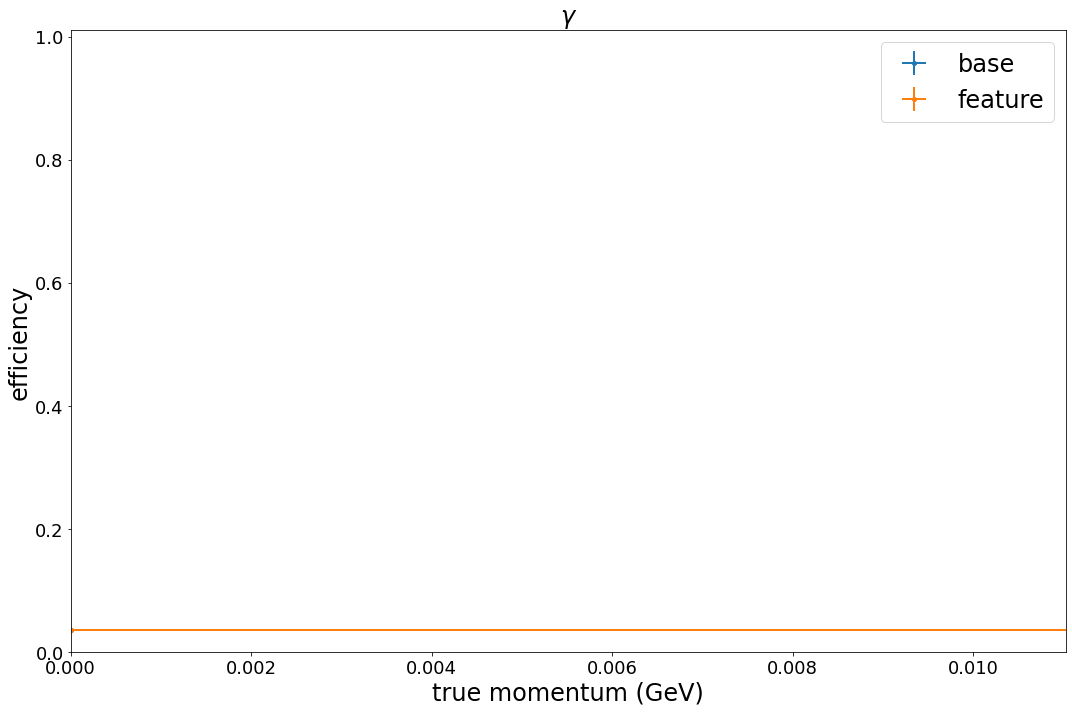

In [108]:
mc_nhits = {"base": None, "feature": None}
mc_mom = {"base": None, "feature": None}
completeness_array = {"base": None, "feature": None}
purity_array = {"base": None, "feature": None}
efficiency_array = {"base": None, "feature": None}
samples = {"base": validation1, "feature": validation2}

for pdg in pdg_to_id:
    for key, value in samples.items():
        idx = np.where(abs(value.mc_pdg) == pdg)
        mc_nhits[key] = value.mc_nhits[idx]
        mc_mom[key] = value.mc_momentum[idx]
        completeness_array[key], purity_array[key], efficiency_array[key] = get_metric_arrays(value, idx)
    make_completeness_plots(pdg, completeness_array, mc_nhits, mc_mom, f"inc_completeness_{pdg}")
    make_purity_plots(pdg, purity_array, mc_nhits, mc_mom, f"inc_purity_{pdg}")
    make_efficiency_plots(pdg, efficiency_array, mc_nhits, mc_mom, f"inc_efficiency_{pdg}")

## Particle metrics by interaction type (CC)

In [ ]:
mc_nhits = {"base": None, "feature": None}
mc_mom = {"base": None, "feature": None}
completeness_array = {"base": None, "feature": None}
purity_array = {"base": None, "feature": None}
efficiency_array = {"base": None, "feature": None}
samples = {"base": validation1, "feature": validation2}

for int_type in ["qe", "res", "dis", "coh"]:
    for pdg in pdg_to_id:
        proceed = True
        for key, value in samples.items():
            if int_type == "qe": type_target = value.is_qe == True
            elif int_type == "res": type_target = value.is_res == True
            elif int_type == "dis": type_target = value.is_dis == True
            elif int_type == "coh": type_target = value.is_coh == True
            type_match = type_target & (value.is_cc == True)
            pdg_match = abs(value.mc_pdg) == pdg
            idx = np.where(pdg_match & type_match)
            if len(idx[0]) > 0:
                mc_nhits[key] = value.mc_nhits[idx]
                mc_mom[key] = value.mc_momentum[idx]
                completeness_array[key], purity_array[key], efficiency_array[key] = get_metric_arrays(value, idx)
            else:
                proceed = False
        if proceed:
            make_completeness_plots(pdg, completeness_array, mc_nhits, mc_mom, f"cc{int_type}_completeness_{pdg}")
            make_purity_plots(pdg, purity_array, mc_nhits, mc_mom, f"cc{int_type}_purity_{pdg}")
            make_efficiency_plots(pdg, efficiency_array, mc_nhits, mc_mom, f"cc{int_type}_efficiency_{pdg}")

## Particle metrics by interaction type (NC)

In [ ]:
mc_nhits = {"base": None, "feature": None}
mc_mom = {"base": None, "feature": None}
completeness_array = {"base": None, "feature": None}
purity_array = {"base": None, "feature": None}
efficiency_array = {"base": None, "feature": None}
samples = {"base": validation1, "feature": validation2}

for int_type in ["qe", "res", "dis", "coh"]:
    for pdg in pdg_to_id:
        proceed = True
        for key, value in samples.items():
            if int_type == "qe": type_target = value.is_qe == True
            elif int_type == "res": type_target = value.is_res == True
            elif int_type == "dis": type_target = value.is_dis == True
            elif int_type == "coh": type_target = value.is_coh == True
            type_match = type_target & (value.is_cc == False)
            pdg_match = abs(value.mc_pdg) == pdg
            idx = np.where(pdg_match & type_match)
            if len(idx[0]) > 0:
                mc_nhits[key] = value.mc_nhits[idx]
                mc_mom[key] = value.mc_momentum[idx]
                completeness_array[key], purity_array[key], efficiency_array[key] = get_metric_arrays(value, idx)
            else:
                proceed = False
        if proceed:
            make_completeness_plots(pdg, completeness_array, mc_nhits, mc_mom, f"nc{int_type}_completeness_{pdg}")
            make_purity_plots(pdg, purity_array, mc_nhits, mc_mom, f"nc{int_type}_purity_{pdg}")
            make_efficiency_plots(pdg, efficiency_array, mc_nhits, mc_mom, f"nc{int_type}_efficiency_{pdg}")

# Event validation

In [ ]:
class EventValidation:
    def __init__(self, filename, treename):
        file = uproot.open(filename)
        tree = file[treename]        
        
        events = tree['event'].array(library="np")
        self.event = tree['event'].array(library="np") #linear list of events
        self.orig_event = tree["event"].array(library="np") #actual event number
        self.file = np.zeros_like(self.event)
        self.is_cc = tree["isCC"].array(library="np")
        self.is_qe = tree["isQE"].array(library="np")
        self.is_res = tree["isResonant"].array(library="np")
        self.is_dis = tree["isDIS"].array(library="np")
        self.is_coh = tree["isCoherent"].array(library="np")
        self.is_numu = tree["isNuMu"].array(library="np")
        self.is_nue = tree["isNuE"].array(library="np")
        self.n_pizero = tree["nPiZero"].array(library="np")
        self.n_pic = tree["nPiMinus"].array(library="np") + tree["nPiPlus"].array(library="np")
        self.n_photons = tree["nPhotons"].array(library="np")
        self.n_protons = tree["nProtons"].array(library="np")
        self.is_fiducial = tree["isFiducial"].array(library="np")
        self.nu_vtx_dx = tree["vtxDx"].array(library="np")
        self.nu_vtx_dy = tree["vtxDy"].array(library="np")
        self.nu_vtx_dz = tree["vtxDr"].array(library="np")
        self.nu_vtx_dr = tree["vtxDz"].array(library="np")
        self.n_good_matches = tree["nGoodMatches"].array(library="np")
        self.n_poor_matches = tree["nPoorMatches"].array(library="np")
        self.n_unmatched = tree["nUnmatched"].array(library="np")
        self.n_nodes = tree["nNodes"].array(library="np")
        self.n_good_tier1_matches = tree["nGoodTier1Matches"].array(library="np")
        self.n_tier1_nodes = tree["nTier1Nodes"].array(library="np")
        self.n_good_track_matches = tree["nGoodTrackMatches"].array(library="np")
        self.n_track_nodes = tree["nTrackNodes"].array(library="np")
        self.n_good_shower_matches = tree["nGoodShowerMatches"].array(library="np")
        self.n_shower_nodes = tree["nShowerNodes"].array(library="np")
        self.n_good_tier1_track_matches = tree["nGoodTier1TrackMatches"].array(library="np")
        self.n_track_tier1_nodes = tree["nTier1TrackNodes"].array(library="np")
        self.n_good_tier1_shower_matches = tree["nGoodTier1ShowerMatches"].array(library="np")
        self.n_tier1_shower_nodes = tree["nTier1ShowerNodes"].array(library="np")
        self.has_leading_muon = tree["hasLeadingMuon"].array(library="np")
        self.has_leading_electron = tree["hasLeadingElectron"].array(library="np")
        self.is_leading_lepton_correct = tree["isLeadingLeptonCorrect"].array(library="np")
        file.close()
        make_sequential(self)

In [ ]:
validation1 = EventValidation("validation_event1.root", "event")
validation2 = EventValidation("validation_event2.root", "event")

In [ ]:
def plot_histogram_2d(base_x, base_y, feature_x, feature_y, plot_format):
    plt.rcParams["figure.figsize"] = (20, 15)
    fig, ax = plt.subplots()
    
    ax.set_title(plot_format.title, fontsize=plot_format.titlesize)
    ax.tick_params(axis='x', labelsize=plot_format.labelsize)
    ax.tick_params(axis='y', labelsize=plot_format.labelsize)
    ax.set_xlabel(plot_format.xlabel, fontsize=plot_format.titlesize)
    ax.set_ylabel(plot_format.ylabel, fontsize=plot_format.titlesize)
    if not plot_format.xlim is None:
        plt.xlim(plot_format.xlim[0], plot_format.xlim[1])
    if not plot_format.ylim is None:
        plt.ylim(plot_format.ylim[0], plot_format.ylim[1])
    
    combined = np.concatenate([base_x, feature_x])
    bins = np.linspace(0, np.max(combined), np.max(combined) + 1)

    base_hist, *_ = np.histogram2d(base_x, base_y, bins=(bins, bins))
    for i in range(len(base_hist)):
        row_sum = base_hist[i].sum()
        base_hist[i] *= 1 / row_sum if row_sum > 0 else 1
    base_hist = base_hist.T
    
    feature_hist, *_ = np.histogram2d(feature_x, feature_y, bins=(bins, bins))
    for i in range(len(feature_hist)):
        row_sum = feature_hist[i].sum()
        feature_hist[i] *= 1 / row_sum if row_sum > 0 else 1
    feature_hist = feature_hist.T

    cmap = plt.cm.get_cmap('coolwarm')
    plt.pcolormesh(bins, bins, feature_hist - base_hist, cmap=cmap, vmin=-1, vmax=1)
    plt.colorbar()
    
    plt.tight_layout()
    save_plot(fig, plot_format.filename)
    
    plt.show()

## Inclusive event metrics

In [ ]:
samples = {"base": validation1, "feature": validation2}
plot_format = PlotFormat(title="Feature - Base : Inclusive", xlabel="true nodes", ylabel="reconstructed nodes",
                         filename=f"inc_particle_frac")
plot_histogram_2d(samples['base'].n_nodes, samples['base'].n_good_matches, samples['feature'].n_nodes,
                  samples['feature'].n_good_matches, plot_format)

In [ ]:
n_protons_array = {"base": None, "feature": None}
efficiency_array = {"base": None, "feature": None}
samples = {"base": validation1, "feature": validation2}

for key, value in samples.items():
    n_protons_array[key] = value.n_nodes
    efficiency_array[key] = np.array(value.n_nodes == value.n_good_matches)
combined = np.concatenate(list(n_protons_array.values()))
bins = np.linspace(0, np.max(combined), 1 + np.max(combined))
plot_format = PlotFormat(title="Correct Event Fraction - Inclusive", xlabel="n protons", ylabel="correct event fraction",
                         xlim=(0, np.max(combined)), ylim=(0, 1.01),
                         filename=f"inc_correct_event_fraction")
metrics = get_efficiency(efficiency_array, n_protons_array, bins)
plot_metric(metrics, plot_format, "efficiency")

## Event metrics by interaction type (CC)

In [ ]:
samples = {"base": validation1, "feature": validation2}

type_match = dict()
for int_type in ["qe", "res", "dis"]:
    for key, value in samples.items():
        if int_type == "qe": type_target = value.is_qe == True
        elif int_type == "res": type_target = value.is_res == True
        elif int_type == "dis": type_target = value.is_dis == True
        elif int_type == "coh": type_target = value.is_coh == True
        type_match[key] = type_target & (value.is_cc == True)
    b_idx = np.where(type_match['base'])
    f_idx = np.where(type_match['feature'])
    if len(b_idx[0]) > 0 and len(f_idx[0]) > 0:
        plot_format = PlotFormat(title=f"Feature - Base : CC{int_type.upper()}", xlabel="true nodes",
                                 ylabel="reconstructed nodes", filename=f"cc{int_type}_particle_frac")
        plot_histogram_2d(samples['base'].n_nodes[b_idx], samples['base'].n_good_matches[b_idx],
                          samples['feature'].n_nodes[f_idx], samples['feature'].n_good_matches[f_idx], plot_format)

In [ ]:
n_protons_array = {"base": None, "feature": None}
efficiency_array = {"base": None, "feature": None}
samples = {"base": validation1, "feature": validation2}

for int_type in ["qe", "res", "dis"]:
    proceed = True
    for key, value in samples.items():
        if int_type == "qe": type_target = value.is_qe == True
        elif int_type == "res": type_target = value.is_res == True
        elif int_type == "dis": type_target = value.is_dis == True
        elif int_type == "coh": type_target = value.is_coh == True
        type_match = type_target & (value.is_cc == True)
        idx = np.where(type_match)
        if len(idx[0]) > 0:
            n_protons_array[key] = value.n_nodes[idx]
            efficiency_array[key] = np.array(value.n_nodes[idx] == value.n_good_matches[idx])
        else:
            proceed = False
    if proceed:
        combined = np.concatenate(list(n_protons_array.values()))
        bins = np.linspace(0, np.max(combined), 1 + np.max(combined))
        plot_format = PlotFormat(title=f"Correct Event Fraction - CC{int_type.upper()}", xlabel="n protons",
                                 ylabel="correct event fraction", xlim=(0, np.max(combined)), ylim=(0, 1.01),
                                 filename=f"cc{int_type}_correct_event_fraction")
        metrics = get_efficiency(efficiency_array, n_protons_array, bins)
        plot_metric(metrics, plot_format, "efficiency")

## Event metrics by interaction type (NC)

In [ ]:
samples = {"base": validation1, "feature": validation2}

type_match = dict()
for int_type in ["qe", "res", "dis"]:
    for key, value in samples.items():
        if int_type == "qe": type_target = value.is_qe == True
        elif int_type == "res": type_target = value.is_res == True
        elif int_type == "dis": type_target = value.is_dis == True
        elif int_type == "coh": type_target = value.is_coh == True
        type_match[key] = type_target & (value.is_cc == False)
    b_idx = np.where(type_match['base'])
    f_idx = np.where(type_match['feature'])
    if len(b_idx[0]) > 0 and len(f_idx[0]) > 0:
        plot_format = PlotFormat(title=f"Feature - Base : NC{int_type.upper()}", xlabel="true nodes",
                                 ylabel="reconstructed nodes", filename=f"nc{int_type}_particle_frac")
        plot_histogram_2d(samples['base'].n_nodes[b_idx], samples['base'].n_good_matches[b_idx],
                          samples['feature'].n_nodes[f_idx], samples['feature'].n_good_matches[f_idx], plot_format)

In [ ]:
n_protons_array = {"base": None, "feature": None}
efficiency_array = {"base": None, "feature": None}
samples = {"base": validation1, "feature": validation2}

for int_type in ["qe", "res", "dis"]:
    proceed = True
    for key, value in samples.items():
        if int_type == "qe": type_target = value.is_qe == True
        elif int_type == "res": type_target = value.is_res == True
        elif int_type == "dis": type_target = value.is_dis == True
        elif int_type == "coh": type_target = value.is_coh == True
        type_match = type_target & (value.is_cc == False)
        idx = np.where(type_match)
        if len(idx[0]) > 0:
            n_protons_array[key] = value.n_nodes[idx]
            efficiency_array[key] = np.array(value.n_nodes[idx] == value.n_good_matches[idx])
        else:
            proceed = False
    if proceed:
        combined = np.concatenate(list(n_protons_array.values()))
        bins = np.linspace(0, np.max(combined), 1 + np.max(combined))
        plot_format = PlotFormat(title=f"Correct Event Fraction - NC{int_type.upper()}", xlabel="n protons",
                                 ylabel="correct event fraction", xlim=(0, np.max(combined)), ylim=(0, 1.01),
                                 filename=f"nc{int_type}_correct_event_fraction")
        metrics = get_efficiency(efficiency_array, n_protons_array, bins)
        plot_metric(metrics, plot_format, "efficiency")